<a href="https://colab.research.google.com/github/souken-b/calc_OWC/blob/main/cal_pulating_pres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1373]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

In [1374]:
T = 2 # 周期
n = 1000 # 分割数
n_diam = 0.008123 # オリフィス直径(m)
D0 = 0.0254 # 円管の直径(m)
A = 5.1823028331816915 * 1e-05 # オリフィスの断面積(m2)
A0 = np.pi * ((D0 / 2) ** 2) # 円管の断面積(m2)
L0 = 0.12 # t=0での空気室高さ(m)
# L0 = 0.15830000000000002 # ピストンロッドの長さ(m)
L = 0.08 # ピストン変位振幅(m)
d_ratio = n_diam / D0 # 絞り直径比
n_ratio = d_ratio ** 2 # 絞り面積比
h_ratio = 1.4 # 比熱比
p_air = 101325 # 大気圧(pa)
dens_air = 1.225 # 空気の密度(kg/m3)
p_0 = p_air + 10 # 圧力の初期値

In [1375]:
def c_ci(d_ratio)->'非圧縮性の縮流係数':
  # flow coefficient
  f_coef = 0.598 - 0.003 * (d_ratio ** 2) + 0.404 * (d_ratio ** 4)
  return (f_coef / ((1 + (d_ratio ** 4) * (f_coef ** 2)) ** (1/2)))

In [1376]:
def force_ci(c_ci)->'非圧縮性力欠損係数':
  return ((1 / c_ci) - (1 / (2 * (c_ci ** 2))))

In [1377]:
def c_c(f_ci_c, p_up, p_air, h_ratio)->'圧縮性の縮流係数':
  p_ratio = p_up / p_air
  h_ratio_rev = 1/ h_ratio
  return ((1 / (2 * f_ci_c)) * (p_ratio ** h_ratio_rev) * (1 - (1 - ((2 * f_ci_c * (1 - h_ratio_rev)) * (1 - (1 / p_ratio)) / (1- (p_ratio) ** (h_ratio_rev - 1))))  ** (1/2)))

In [1378]:
def rounge_kutta(n, T, dpdt:'関数', p_0, p_air, d_ratio, h_ratio, A0, L, L0, A, f_ci_c, c_c, forward_flow, back_flow):
  h = T / n
  t = np.arange(0, T, h)
  p = np.empty(len(t))
  p[0] = p_0
  V0 = np.empty(len(t)) 
  V0[0] = (L0 + L)*A0
  
  # 方程式を解くための反復計算
  for i in range(len(t) -1):
    const_args = [p_air, T, d_ratio, h_ratio, A0, L, L0, A, f_ci_c, c_c, forward_flow, back_flow]
    k_1 = h * dpdt(p[i], t[i], *const_args)
    k_2 = h * dpdt(p[i] + k_1 /2 , t[i] + h/2, *const_args)
    k_3 = h * dpdt(p[i] + k_2 /2 , t[i] + h/2, *const_args)
    k_4 = h * dpdt(p[i] + k_3, t[i] + h, *const_args)
    p[i+1] = p[i] + 1/6 * (k_1 + 2*k_2 + 2*k_3 + k_4)
    V0[i+1] =  (L0 + L*np.cos(c_freq * t[i])) * A0

  
  # # 誤差の計算
  # v = np.empty(n)
  # for i in range(n):
  #   v[i] = np.exp(h*i)
  # e = v - p
  
  return [t, p, V0]

In [1379]:
def forward_flow(c_c_c, A, p_up, p_air, h_ratio, dens_up):
  h_ratio_rev = 1 / h_ratio
  return  (dens_up / 1.225) * (c_c_c * A  * ((p_up / p_air) ** (-1 * h_ratio_rev)) * (((2 / (1 - h_ratio_rev)) * (p_up / dens_up) * (1 - (p_up / p_air) ** (h_ratio_rev - 1))) ** (1 / 2)))

In [1380]:
def back_flow(c_c_c, A, p_air, p_down, h_ratio, dens_air):
  h_ratio_rev = 1 / h_ratio
  return  c_c_c * A  * ((p_air / p_down) ** (-1 * h_ratio_rev)) * (((2 / (1 - h_ratio_rev)) * (p_air / dens_air) * (1 - (p_air / p_down) ** (h_ratio_rev - 1))) ** (1 / 2))

In [1381]:
def dpdt(p0, t, p_air, T, d_ratio, h_ratio, A0, L, L0, A, f_ci_c, c_c:'関数', forward_flow:'関数', back_flow:'関数')->'押出圧力変化':
  # 円振動数ω
  c_freq = 2 * np.pi / T
  h_ratio_rev = 1 / h_ratio
  if (p0 > p_air):
    # 上流密度
    dens0 = 1.225 * ((p0 / p_air) ** (h_ratio_rev))
    c_c_c = c_c(f_ci_c, p0, p_air, h_ratio)
    flow = forward_flow(c_c_c, A, p0, p_air, h_ratio, dens0)
    dpdt = (-7/5) * p0 * ((((-1) * L * c_freq * np.sin(c_freq * t)) / (L0 + L * np.cos(c_freq * t))) + ((1.225 / dens0) * (flow / ((L0 + L * np.cos(c_freq * t)) * A0))))
  elif ((0.0001 <= (p0/p_air)) and ((p0/p_air) <= 0.0002)):
    flow = 0
    dpdt = (-7/5) * p0 * ((((-1) * L * c_freq * np.sin(c_freq * t)) / (L0 + L * np.cos(c_freq * t))) + ((1.225 / dens0) * (flow / ((L0 + L * np.cos(c_freq * t)) * A0))))
  else:
    dens_air = 1.225
    dens0 = 1.225 * ((p0 / p_air) ** (h_ratio_rev))
    c_c_c = c_c(f_ci_c, p_air, p0, h_ratio)
    flow = back_flow(c_c_c, A, p_air, p0, h_ratio, dens_air)
    dpdt = (-7/5) * p0 * ((((-1) * L * c_freq * np.sin(c_freq * t)) / (L0 + L * np.cos(c_freq * t))) + (((1.225 / dens0)**(h_ratio)) * (((-1) * flow) / ((L0 + L * np.cos(c_freq * t)) * A0))))
  return dpdt

In [1382]:
c_ci_c = c_ci(d_ratio)
f_ci_c = force_ci(c_ci_c)
result = rounge_kutta(n, T, dpdt, p_0, p_air, d_ratio, h_ratio, A0, L, L0, A, f_ci_c, c_c, forward_flow, back_flow)
t_list = result[0]
p_list = result[1]
v0_list = result[2]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


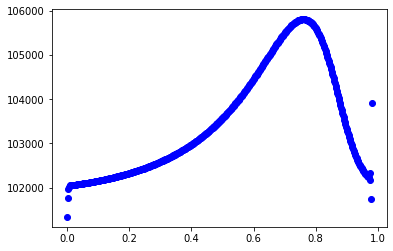

In [1383]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_list, p_list, c='blue')
plt.show()

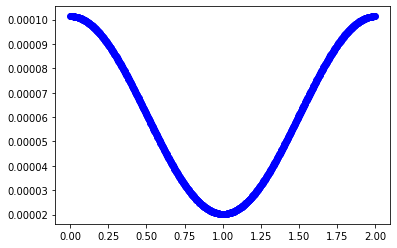

In [1384]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
ax2.scatter(t_list, v0_list, c='blue')
plt.show()